In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from scipy.stats import gaussian_kde
from scipy.stats import ks_2samp
from selenium import webdriver 
import zipfile
from matplotlib import pyplot as plt
import statsmodels.api as sm

In [3]:
response=requests.get('https://en.wikipedia.org/wiki/World_Giving_Index')
soup=BeautifulSoup(response.text,'html.parser')
table=soup.find_all(name='tr')
split_table=[]
for i in table:
    split_table.append(i.text.strip('\n').strip('\xa0').split('\n'))
split_table=np.array(split_table)
p_table=pd.DataFrame(split_table[1:,1:],index=split_table[1:,0],columns=split_table[0,1:])

#followinng this link automatically downloads a zipped folder
driver = webdriver.Chrome(r'C:\Users\bstoutenburg\Downloads\chromedriver.exe')
driver.get('http://databank.worldbank.org/data/download/WDI_csv.zip')

#extract the files from the default downloads folder
zip_ref = zipfile.ZipFile(r'C:\Users\bstoutenburg\Downloads\WDI_csv.zip', 'r')
zip_ref.extractall(r'C:\Users\bstoutenburg\Downloads\ACME\Math403\Data_Project')
zip_ref.close()


data=pd.read_csv('WDIData.csv')

#group the observations by country name 
data_groups=data.groupby('Country Name')
#also create an index so I know which elements correspond to which country
index=[i for i in data_groups.groups.keys()]
#get the groups into a list so we can iterate through them more easily
data_groups_list=[data_groups.get_group(i)[['Indicator Name']+[str(j) for j in range(2004,2018)]].T
                  for i in data_groups.groups.keys()] 

#rename the columns according to indicator name
for i in data_groups_list:
    i.columns=[j for j in i.T['Indicator Name']]
    #only include the years, otherwise we have a column of feature names, feature codes, and country codes
    i=i.T[[str(j) for j in range(2004,2008)]].T

In [4]:
#take a look at what the original looked like
data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Arab World,ARB,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"2005 PPP conversion factor, private consumptio...",PA.NUS.PRVT.PP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,81.844982,82.407647,82.827636,83.169227,83.587141,83.954293,84.230630,84.570425,NaN,NaN
3,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,85.189815,86.136134,86.782683,87.288244,88.389705,88.076774,88.517967,88.768654,NaN,NaN
4,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,73.530494,74.543489,75.770972,76.772916,78.839139,77.487377,78.564439,78.958780,NaN,NaN


In [5]:
#create a list of dataframes and drop indicator name since this is currently given as a row, and we only want the rows to
#be observations, indicator name is what the columns are labeled as, so we have that information already
df_list=[]
for i in range(len(data_groups_list)):
    df_list.append(data_groups_list[i].drop('Indicator Name'))

In [6]:
#scrape the CIA for government classifications
resp=requests.get('https://www.cia.gov/library/publications/the-world-factbook/fields/2128.html')
soup=BeautifulSoup(resp.text,'html.parser')

We need to get the government types of the countries to group them, these seven governemnt types cover the large majority of types as given in the web-page we scraped from:
    -presidential republic
    -presidential democracy
    -parliamentary democracy
    -parliamentary republic
    -consitutional monarchy
    -communist
    -absolute monarchy
The actual values are a little more nuanced than the regular expressions are concerned with, for example the Ukraine is listed as a semi-presidential republic, but this method will simply group it as a presidential republic

In [7]:
#find all the table elements in the html code
table=soup.findAll('td')
#use regex to identify governments
pres_rep=re.compile('president[\s\S]*republic')
pres_dem=re.compile('president[\s\S]*democ')
parl_dem=re.compile('parliam[\s\S]*democ')
parl_rep=re.compile('parliam[\s\S]*republic')
cons_mon=re.compile('consti[\s\S]*monarchy')
comm_sta=re.compile('communist')
abs_mona=re.compile('absolute monarchy')
gov_dict={}
for i in range(0,len(table),2):
    if table[i].text.strip('\n') in index:
        #go through each regular expression and find the one the government matches
        #if there are no matches, map the country to other
        #I access the even elements for country name and odd elements for government name
        if pres_rep.search(table[i+1].text.strip('\n')):
            gov_dict[table[i].text.strip('\n')]='pr_re'
        elif pres_dem.search(table[i+1].text.strip('\n')):
            gov_dict[table[i].text.strip('\n')]='pr_de'
        elif parl_dem.search(table[i+1].text.strip('\n')):
            gov_dict[table[i].text.strip('\n')]='pa_de'
        elif parl_rep.search(table[i+1].text.strip('\n')):
            gov_dict[table[i].text.strip('\n')]='pa_re'
        elif cons_mon.search(table[i+1].text.strip('\n')):
            gov_dict[table[i].text.strip('\n')]='co_mo'
        elif comm_sta.search(table[i+1].text.strip('\n')):
            gov_dict[table[i].text.strip('\n')]='co_st'
        elif abs_mona.search(table[i+1].text.strip('\n')):
            gov_dict[table[i].text.strip('\n')]='ab_mo'
        else:
            gov_dict[table[i].text.strip('\n')]='other'


In [8]:
#take a look at what we have
gov_dict

{'Afghanistan': 'pr_re',
 'Albania': 'pa_re',
 'Algeria': 'pr_re',
 'American Samoa': 'pr_de',
 'Andorra': 'pa_de',
 'Angola': 'pr_re',
 'Antigua and Barbuda': 'pa_de',
 'Argentina': 'pr_re',
 'Armenia': 'pa_de',
 'Aruba': 'pa_de',
 'Australia': 'pa_de',
 'Austria': 'pa_re',
 'Azerbaijan': 'pr_re',
 'Bahamas, The': 'pa_de',
 'Bahrain': 'co_mo',
 'Bangladesh': 'pa_re',
 'Barbados': 'pa_de',
 'Belarus': 'pr_re',
 'Belgium': 'pa_de',
 'Belize': 'pa_de',
 'Benin': 'pr_re',
 'Bermuda': 'pa_de',
 'Bhutan': 'co_mo',
 'Bolivia': 'pr_re',
 'Bosnia and Herzegovina': 'pa_re',
 'Botswana': 'pa_re',
 'Brazil': 'pr_re',
 'British Virgin Islands': 'pa_de',
 'Bulgaria': 'pa_re',
 'Burkina Faso': 'pr_re',
 'Burundi': 'pr_re',
 'Cabo Verde': 'pa_re',
 'Cambodia': 'co_mo',
 'Cameroon': 'pr_re',
 'Canada': 'pa_de',
 'Cayman Islands': 'pa_de',
 'Central African Republic': 'pr_re',
 'Chad': 'pr_re',
 'Chile': 'pr_re',
 'China': 'co_st',
 'Colombia': 'pr_re',
 'Comoros': 'pr_re',
 'Costa Rica': 'pr_re',
 "Co

In [9]:
#create a list for each government type
#I use index which I defined back in the second code box
#index tells me what country each element corresponds to

#in each list comprehension we add a dataframe if the name of the country is in the list of dataframes
#and if the government type of the list we want to add to matches the government type in our gov_dict defined above
pres_rep_gr=[data_groups_list[i] for i in range(len(data_groups_list)) 
             if index[i] in gov_dict.keys() and gov_dict[index[i]]=='pr_re']
pres_dem_gr=[data_groups_list[i] for i in range(len(data_groups_list)) 
             if index[i] in gov_dict.keys() and gov_dict[index[i]]=='pr_de']
parl_rep_gr=[data_groups_list[i] for i in range(len(data_groups_list)) 
             if index[i] in gov_dict.keys() and gov_dict[index[i]]=='pa_re']
parl_dem_gr=[data_groups_list[i] for i in range(len(data_groups_list)) 
             if index[i] in gov_dict.keys() and gov_dict[index[i]]=='pa_de']
cons_mon_gr=[data_groups_list[i] for i in range(len(data_groups_list)) 
             if index[i] in gov_dict.keys() and gov_dict[index[i]]=='co_mo']
comm_sta_gr=[data_groups_list[i] for i in range(len(data_groups_list)) 
             if index[i] in gov_dict.keys() and gov_dict[index[i]]=='co_st']
abs_mona_gr=[data_groups_list[i] for i in range(len(data_groups_list)) 
             if index[i] in gov_dict.keys() and gov_dict[index[i]]=='ab_mo']
other_group=[data_groups_list[i] for i in range(len(data_groups_list)) 
             if index[i] in gov_dict.keys() and gov_dict[index[i]]=='other']

In [10]:
#used features gives a baseline of features that will be included in all groups
used_features=['GDP growth (annual %)','GDP per capita growth (annual %)']
used_features+=['Age dependency ratio (% of working-age population)',
                'Contributing family workers, total (% of total employment) (modeled ILO estimate)',
                'Employers, total (% of total employment) (modeled ILO estimate)',
               'Employment in agriculture (% of total employment) (modeled ILO estimate)',
               'Employment in industry (% of total employment) (modeled ILO estimate)',
               'Employment in services (% of total employment) (modeled ILO estimate)',
               'Employment to population ratio, 15+, total (%) (modeled ILO estimate)',
               'Foreign direct investment, net inflows (% of GDP)',
               'Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)',
               'Mortality rate, infant (per 1,000 live births)',
               'Mortality rate, neonatal (per 1,000 live births)',
               'Mortality rate, under-5 (per 1,000 live births)',
               'Population growth (annual %)',
               'Unemployment, total (% of total labor force) (modeled ILO estimate)',
               'Vulnerable employment, total (% of total employment) (modeled ILO estimate)',
               'Wage and salaried workers, total (% of total employment) (modeled ILO estimate)']

In [11]:
#add features to the baseline for each group
pr_re_features=used_features+['Employers, total (% of total employment) (modeled ILO estimate)',
                             'Immunization, DPT (% of children ages 12-23 months)',
                             'Immunization, measles (% of children ages 12-23 months)',
                             'Inflation, GDP deflator (annual %)',
                             'Merchandise exports (current US$)',
                             'Merchandise imports (current US$)',
                             'Self-employed, total (% of total employment) (modeled ILO estimate)',
                             'Refugee population by country or territory of origin']

pa_re_features=used_features+['Average grace period on new external debt commitments (years)',
                             'Self-employed, total (% of total employment) (modeled ILO estimate)']

pa_de_features=used_features+['Average grace period on new external debt commitments (years)',
                             'Immunization, DPT (% of children ages 12-23 months)',
                             'Immunization, HepB3 (% of one-year-old children)',
                             'Immunization, measles (% of children ages 12-23 months)',
                             'Inflation, consumer prices (annual %)']

co_st_features=used_features+['Agriculture, forestry, and fishing, value added (% of GDP)',
                             'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)',
                             'Average grace period on new external debt commitments (years)',
                             'Commercial service exports (current US$)',
                             'Commercial service imports (current US$)',
                             'Debt forgiveness grants (current US$)',
                             'Gross capital formation (% of GDP)',
                             'Immunization, DPT (% of children ages 12-23 months)',
                             'Immunization, HepB3 (% of one-year-old children)',
                             'Immunization, measles (% of children ages 12-23 months)',
                             'Industry (including construction), value added (% of GDP)',
                             'Inflation, consumer prices (annual %)',
                             'Mobile cellular subscriptions (per 100 people)',
                             'Secondary education, duration (years)',
                             'Primary school starting age (years)']

co_mo_features=used_features+['Average grace period on new external debt commitments (years)',
                             'Debt forgiveness grants (current US$)',
                             'Inflation, consumer prices (annual %)',
                             'Lower secondary school starting age (years)',
                             'Newborns protected against tetanus (%)',
                             'Primary education, duration (years)',
                             'Secondary education, duration (years)',
                             'Self-employed, total (% of total employment) (modeled ILO estimate)',
                             'Start-up procedures to register a business (number)',
                             'Time required to enforce a contract (days)',
                             'Wage and salaried workers, total (% of total employment) (modeled ILO estimate)']

other_features=used_features+['Refugee population by country or territory of asylum',
                              'Total reserves (includes gold, current US$)',
                              'Foreign direct investment, net outflows (% of GDP)',
                              'Fixed telephone subscriptions (per 100 people)',
                              'Mobile cellular subscriptions (per 100 people)',
                              'Immunization, DPT (% of children ages 12-23 months)',
                              'Immunization, measles (% of children ages 12-23 months)',
                              'Merchandise trade (% of GDP)',
                              'Inflation, GDP deflator (annual %)',
                              'Lower secondary school starting age (years)',
                              'Primary education, duration (years)',
                              'Secondary education, duration (years)']

ab_mo_features=used_features+['Fixed broadband subscriptions (per 100 people)',
                             'Fixed telephone subscriptions (per 100 people)',
                             'Foreign direct investment, net outflows (% of GDP)',
                             'Immunization, DPT (% of children ages 12-23 months)',
                             'Immunization, HepB3 (% of one-year-old children)',
                             'Immunization, measles (% of children ages 12-23 months)',
                             'Inflation, consumer prices (annual %)',
                             'Military expenditure (% of GDP)',
                             'Mobile cellular subscriptions (per 100 people)',
                             'Refugee population by country or territory of origin',
                             'Start-up procedures to register a business (number)',
                             'Stocks traded, total value (% of GDP)',
                             'Time required to enforce a contract (days)',
                             'Time required to start a business (days)']

In [12]:
#update each dataframe to include only the selected features
for i in range(len(abs_mona_gr)):
    abs_mona_gr[i]=abs_mona_gr[i][ab_mo_features]
for i in range(len(cons_mon_gr)):
    cons_mon_gr[i]=cons_mon_gr[i][co_mo_features]
for i in range(len(comm_sta_gr)):
    comm_sta_gr[i]=comm_sta_gr[i][co_st_features]
for i in range(len(parl_dem_gr)):
    parl_dem_gr[i]=parl_dem_gr[i][pa_de_features]
for i in range(len(parl_rep_gr)):
    parl_rep_gr[i]=parl_rep_gr[i][pa_re_features]
for i in range(len(pres_rep_gr)):
    pres_rep_gr[i]=pres_rep_gr[i][pr_re_features]
for i in range(len(pres_dem_gr)):
    pres_dem_gr[i]=pres_dem_gr[i][other_features]
for i in range(len(other_group)):
    other_group[i]=other_group[i][other_features]

In [13]:
#drop any observations that still have NaNs
#sm indicates that these are smaller groups now
sm_ab_mo_gr=[]
for i in abs_mona_gr:
    good=i.dropna().drop('Indicator Name')
    if len(good.index)>0:
        sm_ab_mo_gr.append(i.dropna().drop('Indicator Name'))
    
sm_co_mo_gr=[]
for i in cons_mon_gr:
    good=i.dropna().drop('Indicator Name')
    if len(good.index)>0:
        sm_co_mo_gr.append(i.dropna().drop('Indicator Name'))

sm_co_st_gr=[]
for i in comm_sta_gr:
    good=i.dropna().drop('Indicator Name')
    if len(good.index)>0:
        sm_co_st_gr.append(i.dropna().drop('Indicator Name'))
    
sm_pa_de_gr=[]
for i in parl_dem_gr:
    good=i.dropna().drop('Indicator Name')
    if len(good.index)>0:
        sm_pa_de_gr.append(i.dropna().drop('Indicator Name'))
    
sm_pa_re_gr=[]
for i in parl_rep_gr:
    good=i.dropna().drop('Indicator Name')
    if len(good.index)>0:
        sm_pa_re_gr.append(i.dropna().drop('Indicator Name'))
    
sm_pr_re_gr=[]
for i in pres_rep_gr:
    good=i.dropna().drop('Indicator Name')
    if len(good.index)>0:
        sm_pr_re_gr.append(i.dropna().drop('Indicator Name'))
    
sm_pr_de_gr=[]
for i in pres_dem_gr:
    good=i.dropna().drop('Indicator Name')
    if len(good.index)>0:
        sm_pr_de_gr.append(i.dropna().drop('Indicator Name'))
    
sm_other_gr=[]
for i in other_group:
    good=i.dropna().drop('Indicator Name')
    if len(good.index)>0:
        sm_other_gr.append(i.dropna().drop('Indicator Name'))

In [15]:
#since the small presidential democracy group has so few observations, I lump it with the other group
sm_other_gr+=sm_pr_de_gr

Now we will take the log of everything measured in US$ that is non-negative

In [16]:
#if something is measured in dollars, we will take the log
#this is because over time the growth in dollars normally follows an exponential pattern
usd_finder=re.compile(r'US\$')
for i in sm_ab_mo_gr:
    for j in i.columns:
        if usd_finder.search(j):
            if min(np.array(list(i[j][1:])))>0:
                i[j][1:]=np.log(np.array(list(i[j][1:])))
for i in sm_co_mo_gr:
    for j in i.columns:
        if usd_finder.search(j):
            if min(np.array(list(i[j][1:])))>0:
                i[j][1:]=np.log(np.array(list(i[j][1:])))
for i in sm_co_st_gr:
    for j in i.columns:
        if usd_finder.search(j):
            if min(np.array(list(i[j][1:])))>0:
                i[j][1:]=np.log(np.array(list(i[j][1:])))
for i in sm_pa_de_gr:
    for j in i.columns:
        if usd_finder.search(j):
            if min(np.array(list(i[j][1:])))>0:
                i[j][1:]=np.log(np.array(list(i[j][1:])))
for i in sm_pa_re_gr:
    for j in i.columns:
        if usd_finder.search(j):
            if min(np.array(list(i[j][1:])))>0:
                i[j][1:]=np.log(np.array(list(i[j][1:])))
for i in sm_pr_re_gr:
    for j in i.columns:
        if usd_finder.search(j):
            if min(np.array(list(i[j][1:])))>0:
                i[j][1:]=np.log(np.array(list(i[j][1:])))
for i in sm_other_gr:
    for j in i.columns:
        if usd_finder.search(j):
            if min(np.array(list(i[j][1:])))>0:
                i[j][1:]=np.log(np.array(list(i[j][1:])))



In [155]:
#Now we will concatenate our list of dataframes
ab_mo_all=pd.concat(sm_ab_mo_gr)
pr_re_all=pd.concat(sm_pr_re_gr)
pa_de_all=pd.concat(sm_pa_de_gr)
pa_re_all=pd.concat(sm_pa_re_gr)
co_mo_all=pd.concat(sm_co_mo_gr)
co_st_all=pd.concat(sm_co_st_gr)
other_all=pd.concat(sm_other_gr)

In [19]:
#Now we save the dataframes to a csv file for future use
ab_mo_all.to_csv('ab_mo.csv')
pr_re_all.to_csv('pr_re.csv')
pa_de_all.to_csv('pa_de.csv')
pa_re_all.to_csv('pa_re.csv')
co_mo_all.to_csv('co_mo.csv')
co_st_all.to_csv('co_st.csv')
other_all.to_csv('other.csv')

In [20]:
#load the data frames
#when I run code in the future, I only need to run the imports at the top, then from this box on down
ab_mo,co_mo,co_st,other,pa_de,pa_re,pr_re=pd.read_csv('ab_mo.csv'),pd.read_csv('co_mo.csv'),pd.read_csv('co_st.csv'),pd.read_csv('other.csv'),pd.read_csv('pa_de.csv'),pd.read_csv('pa_re.csv'),pd.read_csv('pr_re.csv')

we will run a regression on each variable in each group and plot the one with the highest r_squared value

In [24]:
#put all the dataframes into a list so we can iterate through them easily
dfs=[ab_mo,co_mo,co_st,other,pa_de,pa_re,pr_re]
#Initialize the best r-squared values as a list of zeros
#and the list of best feature names as a list of empty strings
bests1=[0 for i in range(len(dfs))]
bests1_names=['' for i in range(len(dfs))]
#iterate through the groups
for i in range(len(dfs)):
    #iterate through the columns
    for j in dfs[i].columns[3:]:
        x = dfs[i][j]
        x = np.asarray(sm.add_constant(x).astype(float))
        y1 = np.asarray(dfs[i][dfs[i].columns[1]].astype(float))
        #create the model and fit it
        mod1 = sm.OLS(y1, x)
        res1 = mod1.fit()
        #check if the r-squared is better than the current best
        if res1.rsquared_adj>bests1[i]:
            #if it is, replace the value
            bests1[i]=res1.rsquared_adj
            bests1_names[i]=j


C:\Users\bstoutenburg\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


We now will examine how the best variables in each group compare to the other groups.  For example, in communist states where the best single variable fit came from Industry (including construction), value added (% of GDP), did they experience more value added to GDP due to Industries compared to other government types?




In Countries whose government was Absolute Monarchy, the single variable that gave the highest r_squared value was
Employers, total (% of total employment) (modeled ILO estimate).
It had an R squared value of 0.7484442777733069





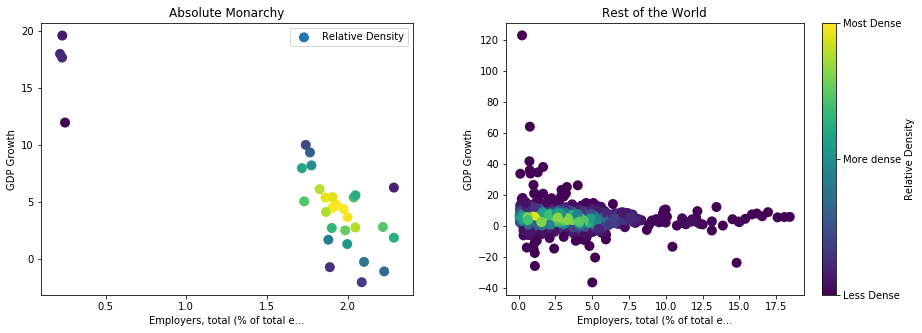



In Countries whose government was Constitutional Monarchy, the single variable that gave the highest r_squared value was
Contributing family workers, total (% of total employment) (modeled ILO estimate).
It had an R squared value of 0.18912450359908173





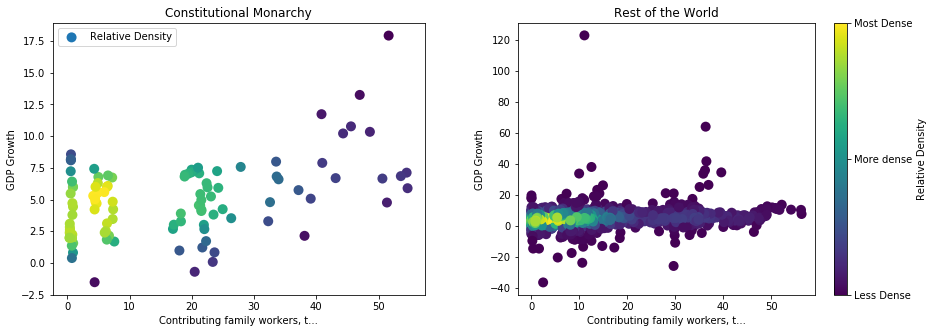



In Countries whose government was Communist State, the single variable that gave the highest r_squared value was
Industry (including construction), value added (% of GDP).
It had an R squared value of 0.6519688139816965





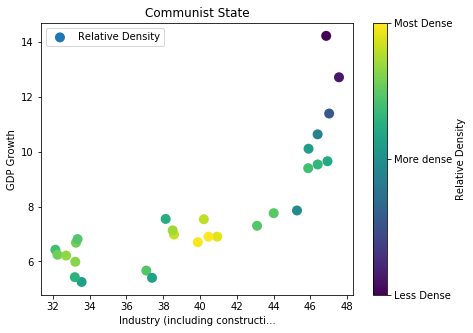



In Countries whose government was Other, the single variable that gave the highest r_squared value was
Employers, total (% of total employment) (modeled ILO estimate).
It had an R squared value of 0.18311028191520318





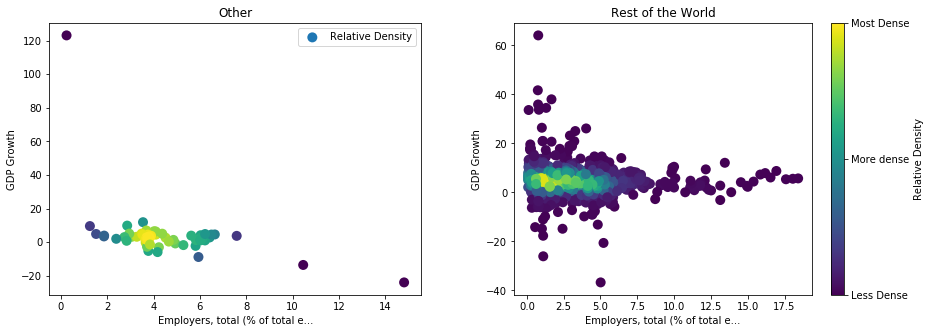



In Countries whose government was Parliamentary Democracy, the single variable that gave the highest r_squared value was
Contributing family workers, total (% of total employment) (modeled ILO estimate).
It had an R squared value of 0.19658127165438977





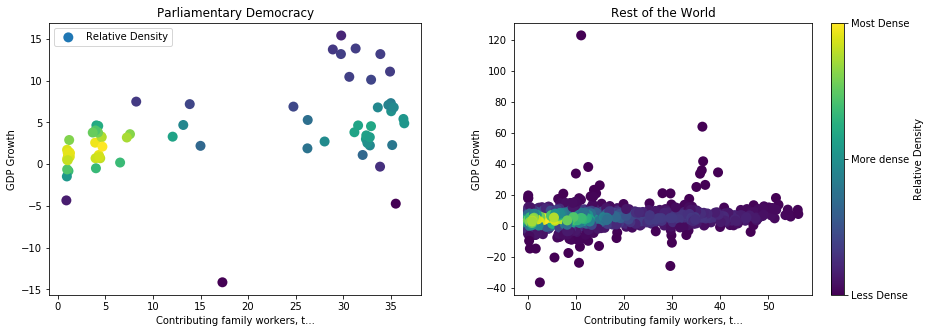



In Countries whose government was Parliamentary Republic, the single variable that gave the highest r_squared value was
Wage and salaried workers, total (% of total employment) (modeled ILO estimate).
It had an R squared value of 0.1361585553986805





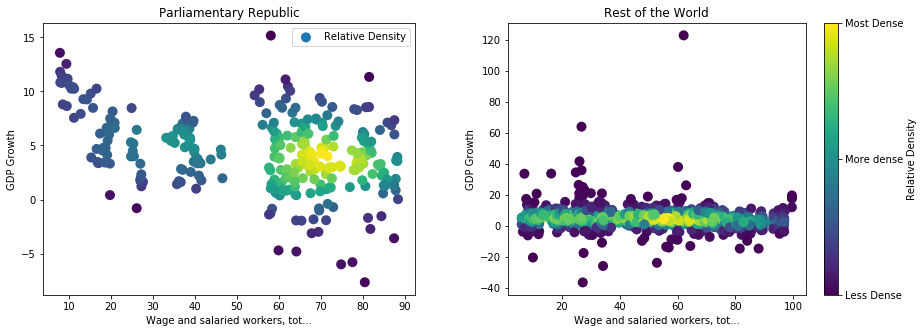



In Countries whose government was Presidential Republic, the single variable that gave the highest r_squared value was
Contributing family workers, total (% of total employment) (modeled ILO estimate).
It had an R squared value of 0.025894515982961774





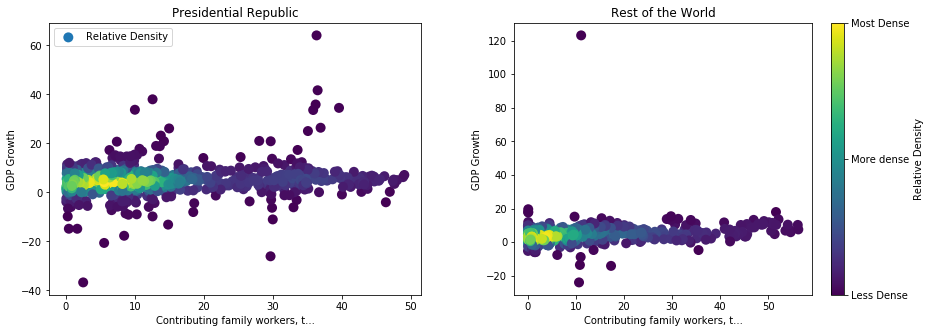

The p-value testing whether Employers, total (% of total employment) (modeled ILO estimate) for countries whose government is Absolute Monarchy 
is different than the rest of the world is 4.1207547109152626e-10
The p-value testing whether Contributing family workers, total (% of total employment) (modeled ILO estimate) for countries whose government is Constitutional Monarchy 
is different than the rest of the world is 5.65441296146487e-07
The p-value testing whether Industry (including construction), value added (% of GDP) for countries whose government is Communist State 
is different than the rest of the world is 4.396029168833573e-20
The p-value testing whether Employers, total (% of total employment) (modeled ILO estimate) for countries whose government is Other 
is different than the rest of the world is 1.7021305328711708e-12
The p-value testing whether Contributing family workers, total (% of total employment) (modeled ILO estimate) for countries whose government is Parliamenta

In [25]:
#initialize p-values to analyze how similar the distributions are
p_values=[]
#create a list of governments for use in the print statements
govs=['Absolute Monarchy','Constitutional Monarchy','Communist State','Other',
      'Parliamentary Democracy','Parliamentary Republic','Presidential Republic']
#plot the distribution for each group's best single variable
for i in range(len(bests1_names)):
    #rest will be used to store the values for all other groups
    rest=[]
    rest_ys=None
    #the best feature for communist countries is alone, so plot it without the rest of the world
    if govs[i]=='Communist State':
        fig,ax=plt.subplots(figsize=(7,5))
    #otherwise create two subplots
    else:
        fig,axes=plt.subplots(1,2,figsize=(15,5))
        ax,ax1=axes[0],axes[1]
    #adjust the white space so labels don't overlap
    fig.subplots_adjust(wspace=.25)
    #iterate through the other dataframes so we can add the values to the rest lists
    for j in range(len(dfs)):
        if i==j:
            #print a message about what is going on
            print('\n\nIn Countries whose government was',govs[i]+', the single variable that gave the highest r_squared value was')
            print(bests1_names[i]+'.')
            print('It had an R squared value of',bests1[i])
            #x1 is the best feature for this group
            x1=np.asarray(dfs[i][bests1_names[i]]).astype(float)
            #y is the next years' gdp growth for this group
            y=np.asarray(dfs[i][dfs[i].columns[1]]).astype(float)
            xy = np.vstack([x1,y])
            
            #use gaussian_kde to approximate the distribution
            z = gaussian_kde(xy)(xy)
            z = (z-np.min(z))/(np.max(z)-np.min(z))
            cax=ax.scatter(x1, y, c=z, s=100, edgecolor='')
            ax.set_title(govs[i])
            
            #only use the first 30 characters since some names are very long, 
            #and we have the whole feature name in the print statement above
            ax.set_xlabel(bests1_names[i][:30]+'...')
            ax.set_ylabel('GDP Growth')
            ax.legend(['Relative Density'])
            cbar=fig.colorbar(cax,ticks=[0,.5,1])
            cbar.set_label('Relative Density')
            cbar.ax.set_yticklabels(['Less Dense','More dense','Most Dense'])
            
        #if we are on a group that is not the one who this feature corresponds to, start adding to the rest of the world
        elif bests1_names[i] in dfs[j].columns:
            if rest_ys is None:
                #if we haven't added anything yet, initialize the xs and ys
                rest_ys=np.asarray(dfs[j][dfs[j].columns[1]]).astype(float)
                rest=np.asarray(dfs[j][bests1_names[i]]).astype(float)
            else:
                #if we have started adding in a previous iteration, stack the old xs and ys with the xs and ys to add
                rest=np.hstack((rest.reshape((1,-1)),np.asarray(dfs[j][bests1_names[i]]).astype(float).reshape((1,-1))))
                rest_ys=np.hstack((rest_ys.reshape((1,-1)),np.asarray(dfs[j][dfs[j].columns[1]]).astype(float).reshape((1,-1))))
    
    #plot the graphs
    if govs[i]!='Communist State':
        x=rest
        y=rest_ys
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        ax1.scatter(x, y, c=z, s=100, edgecolor='')
        ax1.set_title('Rest of the World')
        ax1.set_xlabel(bests1_names[i][:30]+'...')
        ax1.set_ylabel('GDP Growth')
    
    #compare the distributions
    p_values.append(ks_2samp(x.ravel(),x1.ravel())[1])
    print('\n\n')
    plt.show() 
    
#print a message telling us how similar or different the distributions are
for i in range(len(p_values)):
    print('The p-value testing whether',bests1_names[i], 'for countries whose government is',govs[i],
          '\nis different than the rest of the world is',p_values[i])

            

Note, we skipped Communist state since no other country included Industry (including construction), value added (% of GDP) in the data set.

After skimming the graphs, the only groups whose most significant variable was clearly distributed differently than the remaining countires was Absolute Monarchy.  Countries whose government type was absolute monarchy had on average very low refugee populations compared to the rest of the world, and countries whose government type was not included in the six major types had on average very high employment in industry compared to the rest of the world.

We now want to see how the GDP growth of each government type compares across the board

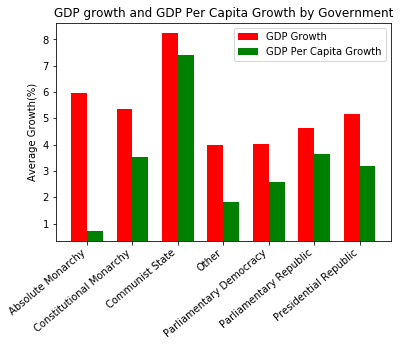

In [26]:
mean_gr=[]
mean_ca_gr=[]
#get the mean values for each group
for i in dfs:
    mean_gr.append(np.asarray(i[i.columns[1]]).astype(float).mean())
    mean_ca_gr.append(np.asarray(i[i.columns[2]]).astype(float).mean())
N = 7


fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, mean_gr, width, color='r', bottom=min(mean_gr+mean_ca_gr))


p2 = ax.bar(ind + width, mean_ca_gr, width,
            color='g', bottom=min(mean_gr+mean_ca_gr))

#define the features of the graph
ax.set_title('GDP growth and GDP Per Capita Growth by Government')
ax.set_xticks(ind + width / 2)
plt.xticks(rotation=40,horizontalalignment="right")
ax.set_xticklabels(govs)
ax.set_ylabel('Average Growth(%)')

ax.legend((p1[0], p2[0]), ('GDP Growth', 'GDP Per Capita Growth'))
ax.autoscale_view()
plt.show()


In [54]:
#calculate how GDP growth varies across groups
gdp_var_year=[]
gdp_years=[]
#iterate through each year and add the gdp growth for each year and the variance for each year to their respective lists
for i in range(2004,2018):
    year=[]
    for j in dfs:
        year.append(np.asarray(j[j.columns[1]][j[j.columns[0]]==i][j[j.columns[1]]<25]).mean())
    gdp_years.append(year)
    gdp_var_year.append(np.var(np.array(year)))
    

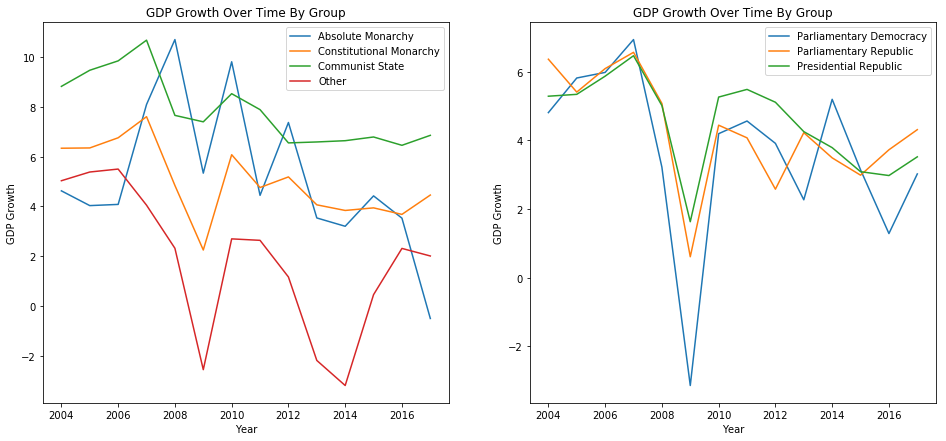

In [73]:
#plot the graphs fo gdp growth by group over time
fig,ax=plt.subplots(1,2,figsize=(16,7))
ax1,ax2=ax[0],ax[1]
for i in range(4):
    ax1.plot(np.arange(2004,2018),gdp_years[:,i])
    ax1.legend(govs[:4])
    ax1.set_title('GDP Growth Over Time By Group')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('GDP Growth')
for i in range(4,7):
    ax2.plot(np.arange(2004,2018),gdp_years[:,i])
    ax2.legend(govs[4:7])
    ax2.set_title('GDP Growth Over Time By Group')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('GDP Growth')
plt.show()

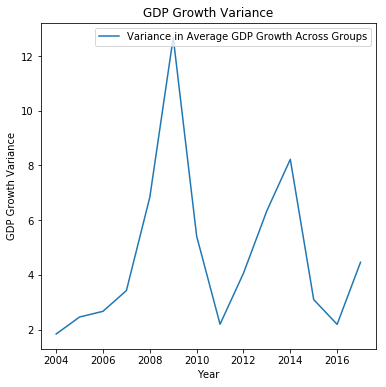

In [154]:
#plot the variance over time
fig,ax=plt.subplots(figsize=(6,6))
ax.plot(np.arange(2004,2018),gdp_var_year,label='Variance in Average GDP Growth Across Groups')
ax.legend(loc='upper right')
ax.set_title('GDP Growth Variance')
ax.set_xlabel('Year')
ax.set_ylabel('GDP Growth Variance')
plt.show()

In [162]:
p=[]
c=0
#run a regression on each group, and record the p-values
for i in dfs:
    if c==2:
        X=i.T[5:].T
        Y=i[i.columns[1]]
    else:
        X=i.T[4:].T
        Y=i[i.columns[1]]
    mod1 = sm.OLS(Y, X)
    res1 = mod1.fit()
    p.append(np.asarray(res1.pvalues).astype(float))
    c+=1

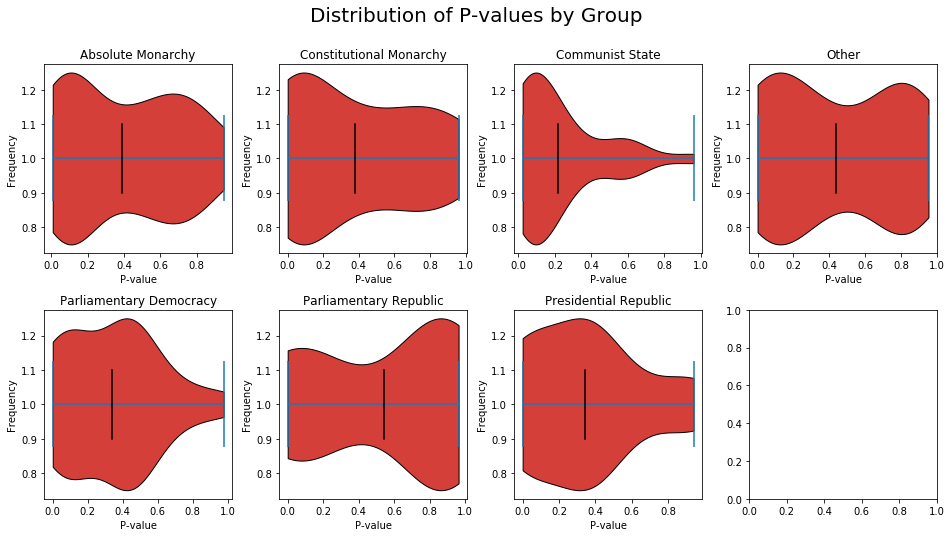

In [153]:
#create a violin plot for each distribution of p-values
fig,axes=plt.subplots(2,4,figsize=(16,8))
fig.subplots_adjust(wspace=.25,hspace=.3)
for i in range(len(p)):
    ax=axes[i//4][i%4]
    parts=ax.violinplot(p[i],vert=False)
    #customize the plots
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    ax.plot(np.ones(2)*np.mean(p[i]),[.9,1.1],'-k')
    ax.set_title(govs[i])
    ax.set_xlabel('P-value')
    ax.set_ylabel('Frequency')
fig.suptitle('Distribution of P-values by Group',fontsize=20)
plt.show()